In [1]:
import os
import time
import cv2
import numpy as np
import feature_extraction as fe
import heatmap as hm
import util

### Image Location

In [2]:
car_directories = ['vehicles/GTI_Far/',
                   'vehicles/GTI_Left/',
                   'vehicles/GTI_Right/',
                   'vehicles/GTI_MiddleClose/',
                   'vehicles/KITTI/']
noncar_directories = ['non-vehicles/GTI/', 'non-vehicles/Extras/']

cars = [os.listdir(car_directory) for car_directory in car_directories]
non_vehicles = [os.listdir(noncar_directory) for noncar_directory in noncar_directories]

### Settings

In [3]:
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins

### Extract Car and Non-Car Features

In [4]:
car_features = []
for car_list, car_directory in zip(cars, car_directories):
    local_car_features = fe.extract_features(car_directory, car_list, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
    car_features.extend(local_car_features)

noncar_features = []
for noncar_list, noncar_directory in zip(non_vehicles, noncar_directories):
    local_noncar_features = fe.extract_features(noncar_directory, noncar_list, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
    noncar_features.extend(local_noncar_features)

### Train Support Vector Machine

In [5]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

X = np.vstack((car_features, noncar_features)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
startTime=time.time()
svc.fit(X_train, y_train)
endTime = time.time()
print("Training Time: ", round(endTime-startTime, 2))
# Check the score of the SVC
print("Test Accuracy: ", round(svc.score(X_test, y_test), 4))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
Training Time:  20.74
Test Accuracy:  0.9887


### Test Images

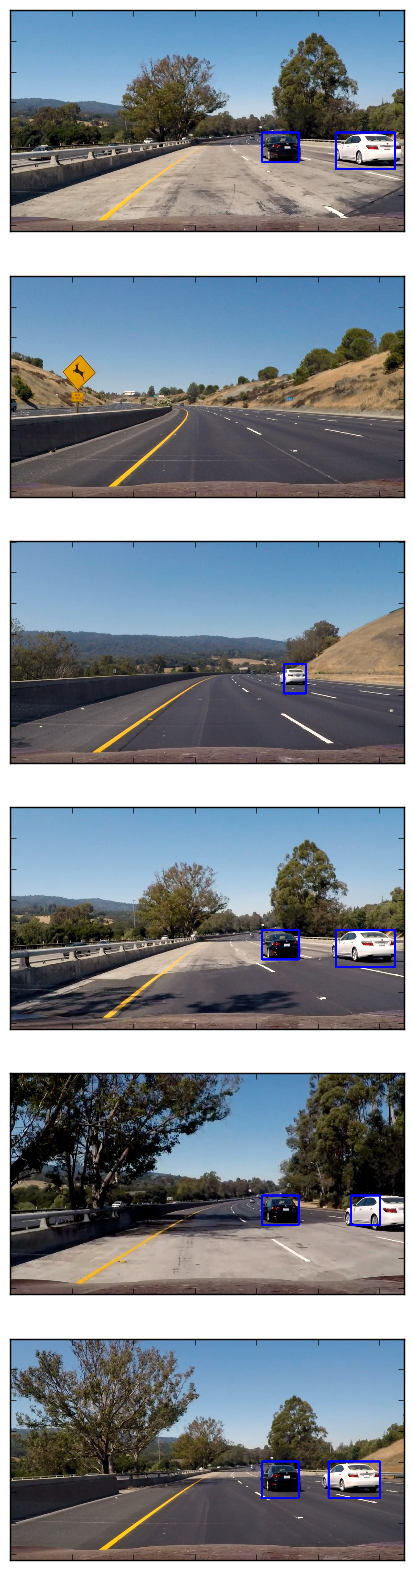

In [6]:
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
nullfmt = NullFormatter()

num_images = 6
ystart = 400
ystop = 656
scale = 1.5

f, axarr = plt.subplots(num_images, 1, figsize=(20,20))
for idx in range(num_images):
    image = cv2.imread('test_images/test{0}.jpg'.format(idx+1))
    heatmap = hm.BoundingBox(image.shape)
    
    on_windows = fe.search_windows(image, ystart, ystop, scale, svc, X_scaler, 
                    spatial_size, hist_bins, 
                    orient, pix_per_cell, cell_per_block)
    
    draw_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    heatmap.add_heat(on_windows)
    result_image = heatmap.draw_labeled_bboxes(draw_image)
    #result_image = util.draw_boxes(draw_image, on_windows)
               
    axarr[idx].imshow(result_image)
    axarr[idx].xaxis.set_major_formatter(nullfmt)
    axarr[idx].yaxis.set_major_formatter(nullfmt)
plt.show()